# 1 Dimensional model of tempreture diffusion 
$$
\frac{\partial u(x,t)}{\partial t} = c_p \frac{\partial^2 u(x,t)}{\partial x^2}$$




## Library imports

In [44]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

## PINN definition
Here we define classical architecture of PINN that is a feed forward fully connected neural network with tanh() activation function

In [45]:
class termPINN_1D(nn.Module):
    def __init__(termPINN_1D, num_hidden = 128, num_layers = 4):
        super(PINN, self).__init__()
        layers = []
        # Input: x,t
        layers.append(nn.Linear(2, num_hidden))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_hidden, num_hidden))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_hidden,1))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

## Definition of collocation points

In [46]:
def generate_collocation_points(Nx=2**8, Nt = 2**8):
    x = torch.linspace(-1,1, Nx)
    t = torch.linspace(0,1,Nt)
    X, T = torch.meshgrid(x,t, indexing='ij')
    points = torch.stack([X.flatten(), T.flatten()], dim=-1)
    points.requires_grad_(True)
    return points, x,t 

In [64]:
pt,_,_ = generate_collocation_points(Nx=2**8, Nt=2**2)
# plt.plot(pt.detach().numpy()[:,0])




# print(pt.detach().numpy().shape)

## Define Partial Differential Equation

In [82]:
def derivative(x,y):
    df = torch.autograd.grad(x,y, grad_outputs=torch.ones_like(y).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_t = df[:, 1:2]
    return df_x, df_t

def PDE(model, cp , points):
    Temp = model(points)
    dT_x, dT_t = derivative(Temp, points)
    dT_xx, _ = derivative(dT_x, points)
    pde = 1*(cp*dT_xx - dT_t)
    return pde

## Dirichlet conditions
def BC_right(model, right_border):
    return model(right_border)
    
def BC_left(model, left_border):
    return model(left_border)    
    
def IC(model, x_points):
    return model(x_points)

def compute_bc_ic_loss(model, points):
    
    
    

SyntaxError: incomplete input (3362233588.py, line 27)

## Define border and initial conditions

tensor([[1.9287e-22, 1.0000e+00],
        [4.2127e-22, 1.0000e+00],
        [9.1449e-22, 1.0000e+00],
        [1.9730e-21, 1.0000e+00],
        [4.2305e-21, 1.0000e+00],
        [9.0156e-21, 1.0000e+00],
        [1.9095e-20, 1.0000e+00],
        [4.0196e-20, 1.0000e+00],
        [8.4095e-20, 1.0000e+00],
        [1.7486e-19, 1.0000e+00],
        [3.6135e-19, 1.0000e+00],
        [7.4216e-19, 1.0000e+00],
        [1.5150e-18, 1.0000e+00],
        [3.0735e-18, 1.0000e+00],
        [6.1971e-18, 1.0000e+00],
        [1.2419e-17, 1.0000e+00],
        [2.4734e-17, 1.0000e+00],
        [4.8959e-17, 1.0000e+00],
        [9.6316e-17, 1.0000e+00],
        [1.8832e-16, 1.0000e+00],
        [3.6595e-16, 1.0000e+00],
        [7.0678e-16, 1.0000e+00],
        [1.3567e-15, 1.0000e+00],
        [2.5881e-15, 1.0000e+00],
        [4.9071e-15, 1.0000e+00],
        [9.2468e-15, 1.0000e+00],
        [1.7318e-14, 1.0000e+00],
        [3.2234e-14, 1.0000e+00],
        [5.9631e-14, 1.0000e+00],
        [1.096

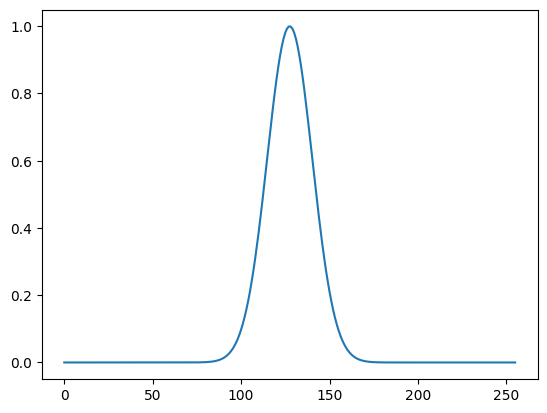

In [81]:
bc_right = pt[pt[:,0] == -1]
bc_left = pt[pt[:,0] == 1]
ic = pt[pt[:,1] == 0]
sigma = 0.02
signal = torch.exp(-ic**2/sigma)
print(signal)
plt.plot(signal.detach().numpy()[:,0])
# print(ic[:,0])

## Training PINN

In [ ]:
model = termPINN_1D(2,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoches = 100
points = generate_collocation_points(Nx=2**8, Nt=100)

for epoch in range(epoches):
    optimizer.zero_grad()
    pde_residual = PDE(model, 1, points)
    pde_loss = torch.mean(pde_residual**2)
    bc_